In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import numpy as np


In [2]:
#load the dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True,image_size=(256,256),batch_size=32)
class_names=dataset.class_names
print(class_names)
print(len(dataset))

Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68


2022-08-05 22:20:03.068171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


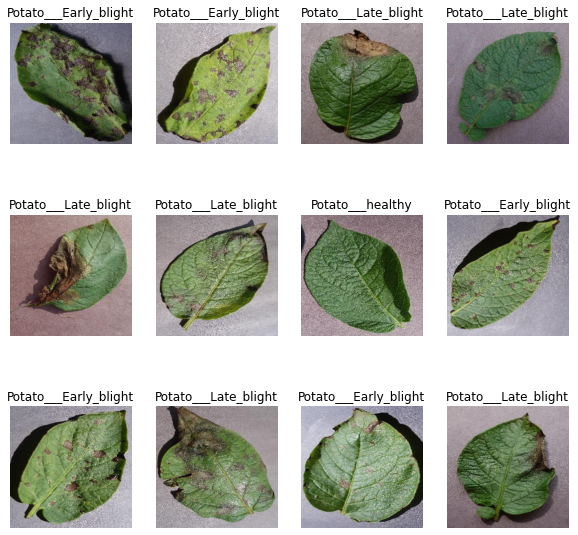

In [3]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):      
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [4]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [5]:
train_ds=dataset.take(54)
len(train_ds)

54

In [6]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [7]:
val_size=0.1
len(dataset)*val_size
val_dataset=test_ds.take(6)
len(val_dataset)

6

In [8]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [9]:
# Train Test Split the model
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
   
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)
len(train_ds)

54

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Preprocessing 
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
# Data Augmentation
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
# Model Building
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(256,256)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
])
model.build(input_shape=(32,256,256,3))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [17]:
history=model.fit(train_ds,epochs=15,validation_data=val_ds,batch_size=32,verbose=1)

Epoch 1/15
54/54 [==============================] - 68s 1s/step - loss: 0.9252 - accuracy: 0.4612 - val_loss: 0.8951 - val_accuracy: 0.4688
Epoch 2/15
54/54 [==============================] - 75s 1s/step - loss: 0.7284 - accuracy: 0.6406 - val_loss: 0.5031 - val_accuracy: 0.7656
Epoch 3/15
54/54 [==============================] - 78s 1s/step - loss: 0.3630 - accuracy: 0.8495 - val_loss: 0.4505 - val_accuracy: 0.7865
Epoch 4/15
54/54 [==============================] - 222s 4s/step - loss: 0.2514 - accuracy: 0.9057 - val_loss: 0.2661 - val_accuracy: 0.8854
Epoch 5/15
54/54 [==============================] - 68s 1s/step - loss: 0.1966 - accuracy: 0.9282 - val_loss: 0.1618 - val_accuracy: 0.9375
Epoch 6/15
54/54 [==============================] - 75s 1s/step - loss: 0.1555 - accuracy: 0.9404 - val_loss: 0.1132 - val_accuracy: 0.9479
Epoch 7/15
54/54 [==============================] - 75s 1s/step - loss: 0.1848 - accuracy: 0.9306 - val_loss: 0.1197 - val_accuracy: 0.9479
Epoch 8/15
54/54 [=

In [18]:
scores= model.evaluate(test_ds)

8/8 [==============================] - 5s 436ms/step - loss: 0.1089 - accuracy: 0.9453


In [19]:
scores

[0.10886536538600922, 0.9453125]

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

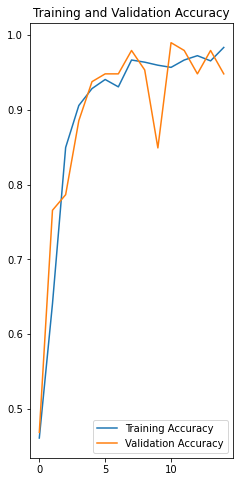

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(15),acc,label="Training Accuracy")
plt.plot(range(15),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

First image to predict
Actual label:  Potato___Late_blight
Predicted label:  Potato___Late_blight


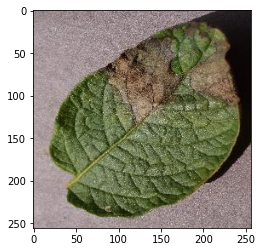

In [25]:
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

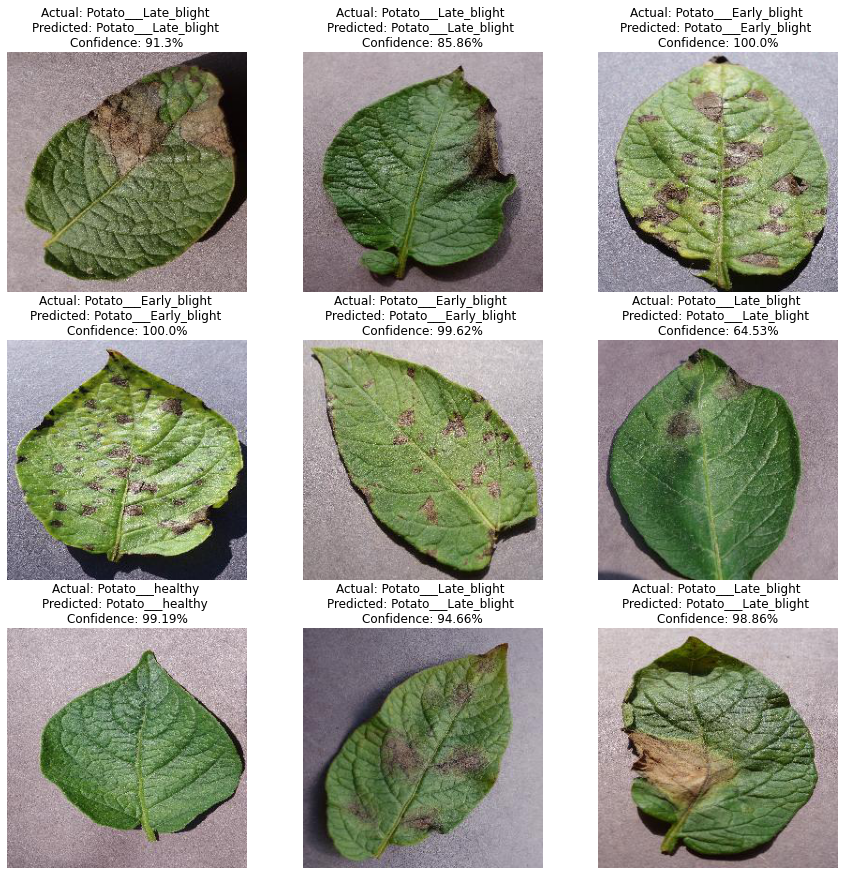

In [27]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class} \nPredicted: {predicted_class} \nConfidence: {confidence}%")
        plt.axis("off")

In [34]:
model_version=2
model.save(f"../models/{model_version}.h5")

In [35]:
import os
os.listdir("../models")

['2.h5', '1.h5']